In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from collections import namedtuple
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

from catch import Catch

from sith import SITH
from memory_hash import HashedMemory

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
print(use_cuda)

True


In [165]:
"""
Reinforcement learning without going too deep.
"""

class SithSR(object):
    """SITH-based Successor Representation"""
    def __init__(self, state_len, action_len,
                 gamma=.9, alpha=.5, num_drifts=3,
                 info_rate=1./30., dt=1./30./10., dur=1./30./10.,
                 dtype=np.float32):
        # save the vars
        self._dtype = dtype
        self._state_len = state_len
        self._action_len = action_len
        self._info_rate = info_rate
        self._dt = dt
        self._dur = dur
        self._delay = info_rate - dt

        self._num_drifts = num_drifts

        self._gamma = gamma
        self._alpha = alpha

        self.history = None

        self._actions = torch.eye(action_len).type(FloatTensor)
        # init sith
        self._in_sith = state_len + action_len
        self._sith = SITH(self._in_sith, dt=self._dt, tau_0=self._info_rate, ntau=25, dtype=self._dtype, use_cuda=use_cuda)
        self._p0 = torch.zeros((self._state_len, 1)).type(FloatTensor)

        # allocate for M
        self._in_M = self._sith.T.size()[0]
        self._M = torch.zeros((self._state_len, self._in_M)).type(FloatTensor) # (outM, inM)

    def reset_T(self):
        self._sith.reset()

    def add_memory(self, reward):
        curr_history = torch.cat((self._sith.T.view(-1).unsqueeze(0),
                                  FloatTensor([reward]).unsqueeze(0)),
                                 1)
        if self.history is None:
            self.history = curr_history
        else:
            self.history = torch.cat((self.history, curr_history), 0)


    def _grab_goal(self, state):
        # Save current t for later
        t_save = self._sith._t.clone()

        # Pull out rewards and features from our history. They are needed
        # in seperate steps
        rewards = self.history[:,-1]
        rewarding = torch.zeros(self.history.size(0)).type(FloatTensor)
        historical_features = self.history[:, :-1]

        # Delay sith and find the reward values from the has table.
        for i in range(self._num_drifts):
            self._sith.update_t(item=None, dur=self._info_rate)
            feature_similarity = torch.mm(historical_features,
                                          self._sith.flatten_T().unsqueeze(1))
            # Take how closely related the historical features, and multiply
            # those by the rewards. This will tell use which history is the
            # closest to ours and the most rewarding.
            rewarding += feature_similarity.view(-1)*rewards
        # Return t to its previous
        self._sith._t = t_save
        self._sith._t_changed = True
        # Pull out the maximumly rewarding state of T from the hash table.
        # That is the goal for our actor
        out = self.history[rewarding.max(0)[1]][:,:-1]

        return out

    def pick_action(self, state):
        # try out various actions and get max reward
        goal_state = self._grab_goal(state)
        t_save = self._sith.t.clone()

        # try out each action
        potential_futures = None

        # we need to reset t to the old t every loop. &
        for a in self._actions:
            
            # update sith
            sa = torch.cat((state, a), 0)
            self._sith.update_t(sa, dur=self._dur)
            self._sith.update_t(item=None, dur=self._delay)

            # pass through M to get reward
            if potential_futures is None:
                potential_futures = self._M.mm(self._sith.T.view(-1, 1)).view(1, -1)
            else:
                potential_futures = torch.cat((potential_futures,
                                               self._M.mm(self._sith.T.view(-1, 1)).view(1, -1)),
                                              0)
            self._sith._t = t_save
            self._sith._t_changed = True
        evidence = potential_futures.mm(goal_state.view(-1, 1)[:self._in_sith-self._action_len])

        value, action_index = evidence.max(0)

        return action_index

    def learn_step(self, state, action):
        # turn into new sa1
        sa1 = torch.cat((state, self._actions[action].view(-1)), 0).unsqueeze(1)
        #sa1_p = torch.cat((sa1, torch.zeros((self._sith.T.size(0) - sa1.size(0), 1)).type(FloatTensor)), 0)
        sa1_p = torch.cat((torch.zeros((self._sith.T.size(0) - sa1.size(0), 1)).type(FloatTensor), sa1), 0)
        # calc prediction from new state
        p1 = self._M.mm(sa1_p)
        # update M based on prediction error
        #perr = state.unsqueeze(1) + self._gamma * p1 - self._p0
        perr = state.unsqueeze(1) - self._p0
        self._M += self._alpha * perr.mm(self._sith.T.unsqueeze(1).t())
        
        # update T with that state action
        self._sith.update_t(item=sa1.view(-1), dur=self._dur)
        self._sith.update_t(item=None, dur=self._delay)

        # prepare for next loop
        self._p0 = p1


In [166]:
# global params
height = 10
width=10
num_actions = 3
input_size = width * height

# how many games to train on every frame
games_per_frame = 10

masks = [0] #[0, 1, 2, 4, 8, 12, 16]

q_sizes = {'RL':[1]}
           #'queue': [1, 5, 10]}
mod_type = ["RL"]
num_runs = 1
model = SithSR(state_len=input_size, action_len=num_actions)

In [167]:
run_base = 'catch_long_lr'
#run_base = 'catch_MSE'
num_games = 100
hidden_size = input_size * 1
per_random_act = .1
# set up the catch environment
c = Catch(screen_height=height, screen_width=width,
          game_over_conditions = {'ball_deletions': 1},
          mask=0, ball_spawn_rate=height+1,)

In [168]:
tot_score = 0.0

# train over total epochs
for e in range(num_games):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    
    #iterate over each game
    while not game_over:
        # t_-1 is the previous observation
        input_tm1 = input_t.clone()


        # Randomly pick an action, or use the
        # Previously calculated action
        if (np.random.rand() <= per_random_act) or (model.history is None):
            action = (torch.rand(1) * (num_actions)).type(LongTensor)
        else:
            action = model.pick_action(input_tm1)

        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

        # t_0, current timestep
        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(state=input_tm1, action=action.cpu().numpy()[0])
        if reward != 0:
            model.add_memory(reward)
            tot_score += reward
    print(e, ": ", tot_score)
    # Reset Game and Model Queue when the game is over.
    

0 :  -1.0
1 :  -2.0
2 :  -3.0
3 :  -4.0
4 :  -5.0
5 :  -6.0
6 :  -7.0
7 :  -8.0
8 :  -9.0
9 :  -10.0
10 :  -11.0
11 :  -12.0
12 :  -11.0
13 :  -12.0
14 :  -13.0
15 :  -14.0
16 :  -15.0
17 :  -14.0
18 :  -15.0
19 :  -16.0
20 :  -17.0
21 :  -18.0
22 :  -19.0
23 :  -18.0
24 :  -19.0
25 :  -20.0
26 :  -19.0
27 :  -18.0
28 :  -19.0
29 :  -18.0
30 :  -17.0
31 :  -16.0
32 :  -15.0
33 :  -16.0
34 :  -17.0
35 :  -18.0
36 :  -17.0
37 :  -18.0
38 :  -19.0
39 :  -20.0
40 :  -19.0
41 :  -20.0
42 :  -21.0
43 :  -22.0
44 :  -23.0
45 :  -22.0
46 :  -21.0
47 :  -20.0
48 :  -21.0
49 :  -22.0
50 :  -23.0
51 :  -22.0
52 :  -21.0
53 :  -20.0
54 :  -21.0
55 :  -22.0
56 :  -23.0
57 :  -22.0
58 :  -23.0
59 :  -24.0
60 :  -25.0
61 :  -24.0
62 :  -23.0
63 :  -24.0
64 :  -25.0
65 :  -24.0
66 :  -23.0
67 :  -24.0
68 :  -23.0
69 :  -24.0
70 :  -25.0
71 :  -26.0
72 :  -27.0
73 :  -26.0
74 :  -27.0
75 :  -28.0
76 :  -29.0
77 :  -30.0
78 :  -29.0
79 :  -30.0
80 :  -31.0
81 :  -32.0
82 :  -31.0
83 :  -30.0
84 :  -31.0

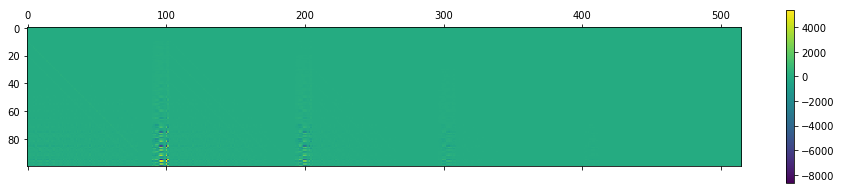

In [169]:
matshow(model._M.cpu().numpy())
colorbar()


In [137]:
model._M


    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
  nan   nan   nan  ...    nan   nan   nan
  nan   nan   nan  ...    nan   nan   nan
  nan   nan   nan  ...    nan   nan   nan
[torch.cuda.FloatTensor of size 100x515 (GPU 0)]

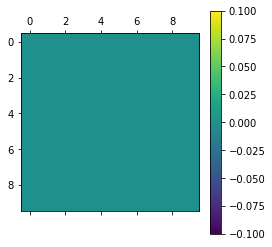

In [8]:
matshow(model._sith.T[0:100].view(10,10).cpu().numpy())
colorbar()

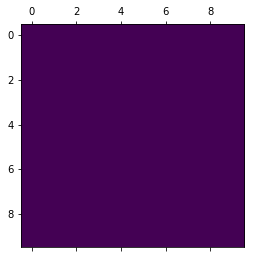

In [260]:
matshow(model._sith.T[103:203].view(10,10).cpu().numpy())

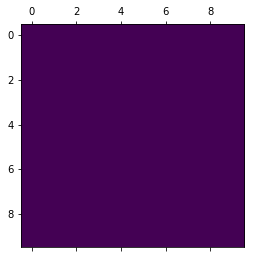

In [261]:
matshow(model._sith.T[206:306].view(10,10).cpu().numpy())

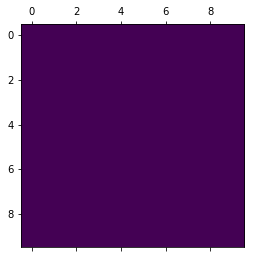

In [262]:
matshow(model._sith.T[0:100].view(10,10).cpu().numpy())

In [170]:
sith = SITH(103, dt=1./30./10., ntau=25, T_every=8, tau_0=1./30.,dtype=np.float32, use_cuda=use_cuda)
actions = torch.eye(3).type(FloatTensor)


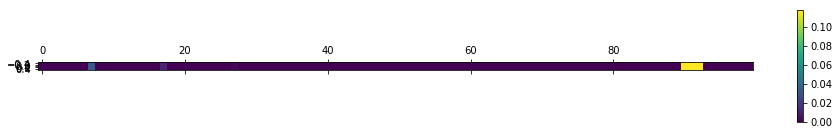

In [216]:
matshow(sith.T.unsqueeze(1).t().cpu().numpy()[:,-103:-3])
colorbar()

In [202]:
input_t = Tensor(c.observe(flatten=True))

In [203]:
input_t.view(10,10)


    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0
    1     1     1     0     0     0     0     0     0     0
[torch.cuda.FloatTensor of size 10x10 (GPU 0)]

In [204]:
sa1 = torch.cat((input_t, actions[0].view(-1)), 0).unsqueeze(1)


In [205]:
sith.update_t(item=sa1.view(-1), dur=1./30./10.)
sith.update_t(item=None, dur=(1./30.) - (1./30./10.))

In [206]:
reward, timestep, game_over = c.act(-1)

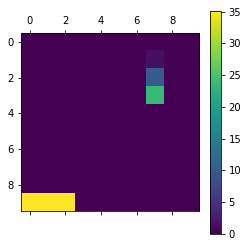

In [207]:
matshow(sith.T[0:100].view(10,10).cpu().numpy())
colorbar()

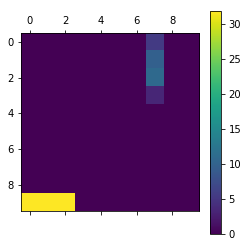

In [208]:
matshow(sith.T[103:203].view(10,10).cpu().numpy())
colorbar()

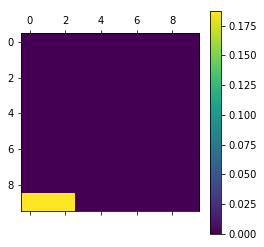

In [178]:
matshow(sith.T[206:306].view(10,10).cpu().numpy())
colorbar()

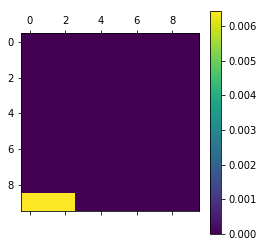

In [179]:
matshow(sith.T[309:409].view(10,10).cpu().numpy())
colorbar()

In [180]:
c.reset()

In [224]:
sith = SITH(103, dt=1./30./10., ntau=25, tau_0=1/30., dtype=np.float32, use_cuda=use_cuda)


In [294]:
sith.tau_star[sith._T_full_ind]

array([ 0.06830134,  0.14641   ,  0.31384283,  0.67275   ,  1.44209933,
        3.09126806], dtype=float32)

In [295]:
sith._T_full_ind  


slice(None, None, 8)

In [296]:
sith._invL


  483.7441   471.4608 -3015.8479  ...      0.0000     0.0000     0.0000
    0.0000   439.7670   428.6008  ...      0.0000     0.0000     0.0000
    0.0000     0.0000   399.7878  ...      0.0000     0.0000     0.0000
              ...                  ⋱                 ...               
    0.0000     0.0000     0.0000  ...    186.5042     0.0000     0.0000
    0.0000     0.0000     0.0000  ...   -102.6039   169.5493     0.0000
    0.0000     0.0000     0.0000  ...   -370.4851   -93.2761   154.1357
[torch.cuda.FloatTensor of size 33x41 (GPU 0)]